## assessing expression and regression to the mean

In [1]:
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, StochasticWeightAveraging, EarlyStopping, LearningRateMonitor, LearningRateFinder

seed_everything(42, workers=True)

from scprint import scPrint
from scprint.trainer import TrainingMode
from scdataloader import DataModule
import pandas as pd

import torch
torch.set_float32_matmul_precision('medium')

%load_ext autoreload
%autoreload 2

Global seed set to 42


💡 lamindb instance: jkobject/scprint


In [2]:
# TODO: drop tissue & dev stage until part or is taken in account

hierarchical_labels = [
    "cell_type_ontology_term_id", #1
    # "tissue_ontology_term_id",
    "disease_ontology_term_id", # 2
#    "development_stage_ontology_term_id",
    "assay_ontology_term_id", #3
    'self_reported_ethnicity_ontology_term_id', #4
]
labels_to_pred = hierarchical_labels+[
    'sex_ontology_term_id', #5
    "organism_ontology_term_id", #6
]
all_labels = labels_to_pred+[
    #'dataset_id',
    'cell_culture',
    "heat_diff",
    "total_counts",
    "nnz",
    "dpt_group",
]

gene_emb = '../data/temp/embeddings.parquet'
d_model=128

In [ ]:
# we might want not to order the genes by expression (or do it?)
# we might want to not introduce zeros and 

In [ ]:
datamodule = DataModule(
    collection_name="preprocessed dataset",
    #gene_embeddings=gene_emb,
    all_labels=all_labels,
    hierarchical_labels=hierarchical_labels,
    organisms=["NCBITaxon:9606"],
    how="all",
    #max_len=1000,
    #add_zero_genes=100,
    label_to_weight=labels_to_pred,
    label_to_pred=labels_to_pred,
    batch_size=64,
    num_workers=8,
    train_oversampling=5,
    validation_split=0.1,
    weight_scaler = 2,
    #do_gene_pos='../data/main/biomart.parquet',
    test_split=0.1
    )
testfiles = datamodule.setup()

won't do any check but we recommend to have your dataset coming from local storage

82.22222222222223% are aligned
total dataset size is 104.788359405 Gb
---
dataset contains:
     5527449 cells
     70116 genes
     11 labels
     1 organisms
dataset contains 230 classes to predict

downloading gene names from biomart
['ensembl_gene_id', 'hgnc_symbol', 'gene_biotype', 'entrezgene_id', 'start_position', 'chromosome_name']
reduced the size to 0.6722574020195106
these files will be considered test datasets:
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.002277723412735242


## dataset types

In [5]:
from collections import Counter
from scdataloader.utils import translate

In [ ]:
contains a lot of:
- lung
- brain
- muscle
- bone marrow
- kidney
- blood
- colon

contains some:
- breast
- intestine, 
- heart, 
- skin, 
- gonad
- retina
- thymus
- gallbladder
- placenta
- uterus
- thyroid
- pancreas
- stomach
- esophagus

In [12]:
translate(Counter(datamodule.dataset.mapped_dataset.get_merged_labels("tissue_ontology_term_id")), "tissue")

{'transverse colon': 26009,
 'duodenum': 6529,
 'jejunum': 7725,
 'descending colon': 1337,
 'ascending colon': 3189,
 'ileum': 76365,
 'blood': 1406590,
 'cortex of kidney': 263865,
 'kidney': 377524,
 'islet of Langerhans': 96119,
 'cerebral nuclei': 134872,
 'breast': 7004,
 'renal medulla': 75192,
 'hypothalamus': 46879,
 'bone marrow': 194410,
 'lower lobe of left lung': 11059,
 'venous blood': 17625,
 'bronchopulmonary lymph node': 16527,
 'renal papilla': 20338,
 'myelencephalon': 62367,
 'spinal cord': 29163,
 'cerebellum': 59369,
 'lamina propria of small intestine': 687,
 'small intestine': 46745,
 'ileal epithelium': 597,
 'heart left ventricle': 210255,
 'zone of skin': 15193,
 'gonad': 268804,
 'mesonephros': 14803,
 'hippocampal formation': 73916,
 'lung': 227122,
 'thoracic lymph node': 62647,
 'mesenteric lymph node': 37155,
 'skeletal muscle tissue': 835,
 'liver': 39879,
 'spleen': 87347,
 'omentum': 13409,
 'caecum': 10911,
 'thymus': 4869,
 'sigmoid colon': 9508,
 '

In [ ]:
10x 3' v3: 2.4M
10x 5' v1: 2M
microwell-seq 0.6M
Slide-seqV2 0.3M

In [13]:
translate(Counter(datamodule.dataset.mapped_dataset.get_merged_labels("assay_ontology_term_id")), "assay")

{"10x 3' v3": 1824961,
 "10x 5' transcription profiling": 600928,
 'Slide-seqV2': 324205,
 "10x 5' v1": 1159435,
 "10x 3' v2": 628324,
 'Visium Spatial Gene Expression': 36489,
 "10x 5' v2": 168520,
 '10x multiome': 51620,
 'microwell-seq': 583546,
 'Smart-seq': 12459,
 'Drop-seq': 118647,
 '10x scATAC-seq': 18315}

## avg expression and avg nnz

In [6]:
import numpy as np
import tqdm

In [ ]:
avg_expr = np.zeros(70116)
is_expr = np.zeros(70116)
num = 0
nnz = []
for n, i in tqdm.tqdm(enumerate(datamodule.train_dataloader())):
    nnz.extend((i['x']>0).sum(1).tolist())
    avg_expr += np.array(i['x'].sum(0))
    is_expr += np.array((i['x']>0).sum(0))
    num += i['x'].shape[0]
    #print(num)
    if n>2000:
        break

1001it [01:28, 11.32it/s]


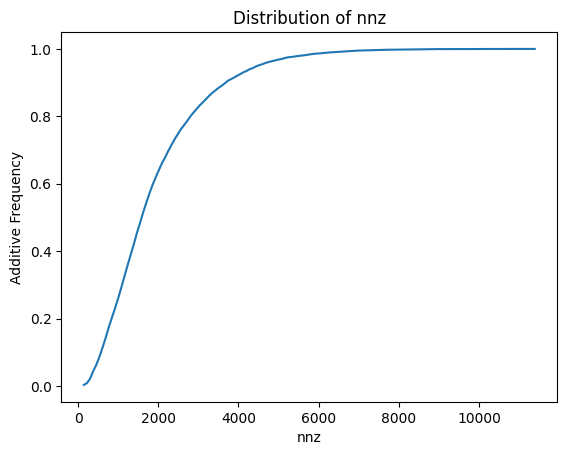

In [ ]:
# with weighted random sampling
import matplotlib.pyplot as plt

# Convert nnz list to numpy array
nnz_array = np.array(nnz)

# Plot histogram with density=True to show additive frequency
counts, bin_edges = np.histogram(nnz_array, bins='auto', density=True)
cumulative_counts = np.cumsum(counts)
plt.plot(bin_edges[1:], cumulative_counts / cumulative_counts[-1])
plt.title("Distribution of nnz")
plt.xlabel("nnz")
plt.ylabel("Additive Frequency")
plt.show()

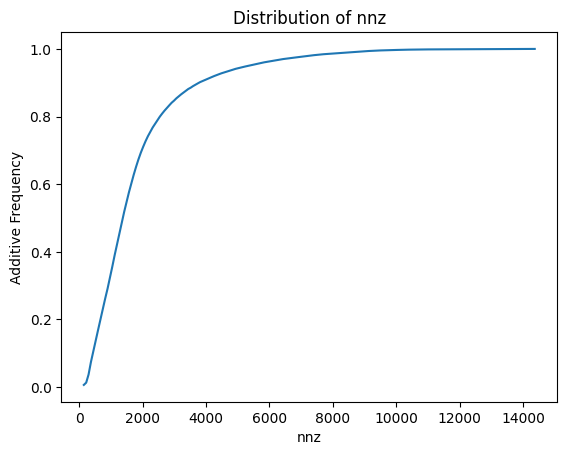

In [16]:
import matplotlib.pyplot as plt

# Convert nnz list to numpy array
nnz_array = np.array(nnz)

# Plot histogram with density=True to show additive frequency
counts, bin_edges = np.histogram(nnz_array, bins='auto', density=True)
cumulative_counts = np.cumsum(counts)
plt.plot(bin_edges[1:], cumulative_counts / cumulative_counts[-1])
plt.title("Distribution of nnz")
plt.xlabel("nnz")
plt.ylabel("Additive Frequency")
plt.show()

In [ ]:
(is_expr>500).sum()

7316

In [15]:
(is_expr>500).sum()

17581

In [16]:
val = np.nan_to_num(avg_expr/is_expr)
val[is_expr<=5] = 0
datamodule.dataset.genedf['avg_expr'] = avg_expr / num
datamodule.dataset.genedf['avg_expr_wexpr'] = val


/tmp/ipykernel_374669/680589537.py:1: RuntimeWarning: invalid value encountered in divide
  val = np.nan_to_num(avg_expr/is_expr)


44923 genes expressed at least once, 

but 29k at least 0.1% of the time, 

and 19k at least 1% of the time

avg of 2000 genes expressed.

2500 seems best, to reach 80% coverage over cells (will be lower after resampling)

In [ ]:
datamodule.dataset.genedf[datamodule.dataset.genedf['avg_expr']>0].shape

(44996, 7)

In [19]:
datamodule.dataset.genedf.to_parquet('../../data/avg_expr.parquet')

In [17]:
datamodule.dataset.genedf

,hgnc_symbol,gene_biotype,entrezgene_id,start_position,chromosome_name,pos,avg_expr,avg_expr_wexpr
ensembl_gene_id,,,,,,,,
ENSG00000000003,TSPAN6,protein_coding,7105.0,100627108,X,45996,0.130419,1.737447
ENSG00000000005,TNMD,protein_coding,64102.0,100584936,X,45995,0.032622,1.332873
ENSG00000000419,DPM1,protein_coding,8813.0,50934867,20,24049,0.304160,1.641880
ENSG00000000457,SCYL3,protein_coding,57147.0,169849631,1,2679,0.073813,1.180270
ENSG00000000460,C1orf112,protein_coding,55732.0,169662007,1,2674,0.041462,1.184452
...,...,...,...,...,...,...,...,...
ENSG00000292369,ENSG00000292369,lncRNA,NaN,57190738,Y,47135,0.000000,0.000000
ENSG00000292370,WASIR1,lncRNA,NaN,57201143,Y,47136,0.000000,0.000000
ENSG00000292371,DDX11L16,unprocessed_pseudogene,NaN,57212184,Y,47136,0.000000,0.000000
